In [1]:
import os
import math
import random
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
import librosa
from matplotlib import pyplot as plt
%matplotlib inline

In [14]:
NUM_LABELS = 10

def genOneHot(indexToBeOne):
    global NUM_LABELS
    oneHot = []
    for i in range(NUM_LABELS):
        if i == indexToBeOne:
            oneHot.append(1)
        else:
            oneHot.append(0)
    return np.array(oneHot)

def extractFeatures(raw, sr):
    mel = np.mean(librosa.feature.melspectrogram(raw, sr=sr).T,axis=0)
    
    return mel
    
def loadSoundFiles(filePath, index):
    IDEAL_SIZE = 22050
    NUM_SAMPLES = 1200
    oneHots = []
    soundFiles = os.listdir(filePath)
    features = np.empty((0, 128))
    
    counter = 0
    for soundFile in soundFiles:
        raw, sr = librosa.load(filePath + soundFile)
        if len(raw) == IDEAL_SIZE:
            mel = extractFeatures(raw, sr)
            internalFeatures = np.hstack([mel])
            features = np.vstack([features, internalFeatures])
            counter += 1
            
            oneHot = genOneHot(index)
            if len(oneHots) == 0:
                oneHots = oneHot
            else:
                oneHots = np.vstack((oneHots, oneHot))
        
            if (counter % (NUM_SAMPLES / 10)) == 0:
                print(str((counter/NUM_SAMPLES) * 100) + "% complete")
        
            if counter == NUM_SAMPLES:
                break
            
    print("The one hot signature for this word is: " + str(oneHots[0]))
    print("The number of samples for this word is: " + str(len(features)))
        
    return np.array(features), oneHots
    
data = []
oneHots = []
rootDir = "./train/audio/"
acceptedWords = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
count = 1
for acceptedWord in acceptedWords:
    print(str(count) + "/" + str(NUM_LABELS))
    features, oneHot = loadSoundFiles(rootDir + acceptedWord + "/", count-1)
    data.append(features)
    oneHots.append(oneHot)
    count += 1
    
print("DONE")

1/10
10.0% complete
20.0% complete
30.0% complete
40.0% complete
50.0% complete
60.0% complete
70.0% complete
80.0% complete
90.0% complete
100.0% complete
The one hot signature for this word is: [1 0 0 0 0 0 0 0 0 0]
The number of samples for this word is: 1200
2/10
10.0% complete
20.0% complete
30.0% complete
40.0% complete
50.0% complete
60.0% complete
70.0% complete
80.0% complete
90.0% complete
100.0% complete
The one hot signature for this word is: [0 1 0 0 0 0 0 0 0 0]
The number of samples for this word is: 1200
3/10
10.0% complete
20.0% complete
30.0% complete
40.0% complete
50.0% complete
60.0% complete
70.0% complete
80.0% complete
90.0% complete
100.0% complete
The one hot signature for this word is: [0 0 1 0 0 0 0 0 0 0]
The number of samples for this word is: 1200
4/10
10.0% complete
20.0% complete
30.0% complete
40.0% complete
50.0% complete
60.0% complete
70.0% complete
80.0% complete
90.0% complete
100.0% complete
The one hot signature for this word is: [0 0 0 1 0 0 0 

In [15]:
dataTraining = []
trainingLabels = []
dataTest = []
testLabels = []

minSamples = 1000000
for training in data:
    if minSamples > len(training):
        minSamples = len(training)

numTrainingSamples = int(minSamples * 0.8)
numTestSamples = int(minSamples * 0.2)

for datasubset in data:
    if len(dataTraining) == 0:
        dataTraining = datasubset[:numTrainingSamples]
        dataTest = datasubset[numTrainingSamples:numTrainingSamples+numTestSamples]
    else:
        dataTraining = np.vstack((dataTraining, datasubset[:numTrainingSamples]))
        dataTest = np.vstack((dataTest, datasubset[numTrainingSamples:numTrainingSamples+numTestSamples]))
               
for oneHotInfo in oneHots:
    if len(trainingLabels) == 0:
        trainingLabels = oneHotInfo[:numTrainingSamples]
        testLabels = oneHotInfo[numTrainingSamples:numTrainingSamples+numTestSamples]
    else:
        trainingLabels = np.vstack((trainingLabels, oneHotInfo[:numTrainingSamples]))
        testLabels = np.vstack((testLabels, oneHotInfo[numTrainingSamples:numTrainingSamples+numTestSamples]))

print("Finished formatting the data to remove bias and to be ready for training")

Finished formatting the data to remove bias and to be ready for training


In [16]:
dataTraining, trainingLabels = shuffle(dataTraining, trainingLabels)
dataTest, testLabels = shuffle(dataTest, testLabels)
print("Randomized the order of the data and labels keeping the relationship 1 to 1")

Randomized the order of the data and labels keeping the relationship 1 to 1


In [82]:
def getBatch(data, labels, batchSize):
    randomIndexes = np.random.choice(len(data), batchSize)
    return data[randomIndexes], labels[randomIndexes]

In [83]:
tf.reset_default_graph()

NUM_SAMPLES = 128
NUM_CLASSIFICATIONS = NUM_LABELS
DENSE_LAYER = 1024
RATE = 0.001
BATCH_SIZE = 100
EPOCHS = 10000
ITERATIONS_PER_EPOCH = 50

x = tf.placeholder(tf.float32, (None, NUM_SAMPLES))
ref = tf.placeholder(tf.float32, (None, NUM_CLASSIFICATIONS))
logits1 = tf.layers.dense(inputs=x, units=DENSE_LAYER, activation=tf.nn.relu, name="L1")
logits2 = tf.layers.dense(inputs=logits1, units=NUM_CLASSIFICATIONS, activation=None, name="L2")
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits2, labels=ref))

optimizer = tf.train.GradientDescentOptimizer(RATE).minimize(cost)
s = tf.Session()
s.run(tf.global_variables_initializer())

count = 0
trainingErrors = []
crossErrors = []
for _ in range(EPOCHS):
    inputData, correctAns = getBatch(dataTraining, trainingLabels, BATCH_SIZE)
    crossData, crossAns = getBatch(dataTraining, trainingLabels, BATCH_SIZE)
    for _ in range(ITERATIONS_PER_EPOCH):
        s.run((optimizer), feed_dict={x: inputData, ref: correctAns})
        count += 1
        if (count % ((EPOCHS * ITERATIONS_PER_EPOCH) / 100)) == 0:
            err = s.run((cost), feed_dict={x: inputData, ref: correctAns})
            crossErr = s.run((cost), feed_dict={x: crossData, ref: crossAns})
            trainingErrors.append(err)
            crossErrors.append(crossErr)
            print(str(int(((count / (EPOCHS * ITERATIONS_PER_EPOCH)) * 100) + 0.5)) + "% complete: Training Error = " + str(err) + ". Cross Validation Error = " + str(crossErr))

1% complete: Training Error = 1.37162. Cross Validation Error = 2.07203
2% complete: Training Error = 1.22564. Cross Validation Error = 2.18461
3% complete: Training Error = 1.15274. Cross Validation Error = 2.56605
4% complete: Training Error = 1.28012. Cross Validation Error = 2.16136
5% complete: Training Error = 1.22611. Cross Validation Error = 1.7387
6% complete: Training Error = 1.1515. Cross Validation Error = 2.34541
7% complete: Training Error = 1.06697. Cross Validation Error = 2.02415
8% complete: Training Error = 1.21552. Cross Validation Error = 2.01177
9% complete: Training Error = 1.08734. Cross Validation Error = 1.87586
10% complete: Training Error = 1.09685. Cross Validation Error = 1.78932
11% complete: Training Error = 1.0821. Cross Validation Error = 1.44414
12% complete: Training Error = 0.872118. Cross Validation Error = 1.60564
13% complete: Training Error = 1.02277. Cross Validation Error = 1.88818
14% complete: Training Error = 1.0426. Cross Validation Error 

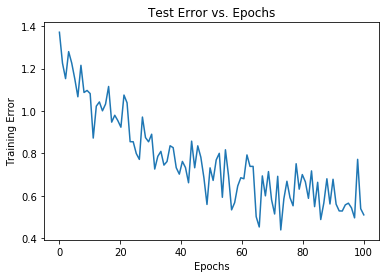

In [84]:
epochs = np.linspace(0, len(trainingErrors), len(trainingErrors))

plt.plot(epochs, trainingErrors)
plt.ylabel('Training Error')
plt.xlabel('Epochs')
plt.title('Test Error vs. Epochs')
plt.show()

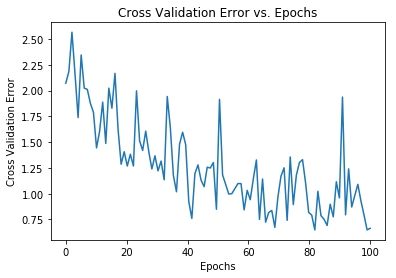

In [85]:
plt.plot(epochs, crossErrors)
plt.ylabel('Cross Validation Error')
plt.xlabel('Epochs')
plt.title('Cross Validation Error vs. Epochs')
plt.show()

In [86]:
probability = tf.nn.softmax(logits2)
prediction = tf.argmax((probability), axis=1)
guesses = s.run((prediction), feed_dict={x: dataTraining})

count = 0
corr = 0
categoriesRight = np.zeros(10)
for trainingLabel in trainingLabels:
    if (np.argmax(trainingLabel)) == guesses[count]:
        corr += 1
        categoriesRight[np.argmax(trainingLabel)] += 1
    count += 1

print("The mlp neural network is " + str((corr / len(guesses)) * 100) + "% accurate on the training data")
print(acceptedWords)
count = 0
print((categoriesRight / numTrainingSamples) * 100)

The mlp neural network is 76.22916666666667% accurate on the training data
['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
[ 83.75        70.52083333  87.70833333  78.75        64.47916667
  75.41666667  79.89583333  73.125       77.70833333  70.9375    ]


In [87]:
probability = tf.nn.softmax(logits2)
prediction = tf.argmax((probability), axis=1)
guesses = s.run((prediction), feed_dict={x: dataTest})

count = 0
corr = 0
categoriesRight = np.zeros(10)
for testLabel in testLabels:
    if (np.argmax(testLabel)) == guesses[count]:
        corr += 1
        categoriesRight[np.argmax(testLabel)] += 1
    count += 1
    
print("The mlp neural network is " + str((corr / len(guesses)) * 100) + "% accurate on the test data")
print(acceptedWords)
print((categoriesRight / numTestSamples) * 100)

The mlp neural network is 44.458333333333336% accurate on the test data
['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
[ 62.5         38.75        61.25        38.33333333  31.25        43.75
  47.91666667  40.          40.83333333  40.        ]


In [42]:
cnnTraining = dataTraining
cnnTrainingLabels = trainingLabels
cnnTest = dataTest
cnnTestLabels = testLabels

def fixShape(data):
    return data.reshape(-1, 1, 128, 1)

In [71]:
tf.reset_default_graph()

NUM_SAMPLES = 128
DENSE_LAYER = 1024
NUM_CLASSIFICATIONS = NUM_LABELS
RATE = 0.001
BATCH_SIZE = 100
EPOCHS = 10000
ITERATIONS_PER_EPOCH = 50
DROP_OUT_RATE = 0.5

class N():
    pass

model = N()

model.x = tf.placeholder(tf.float32, (None, 1, None, 1))
model.ref = tf.placeholder(tf.float32, (None, NUM_CLASSIFICATIONS))
model.drop = tf.placeholder(tf.float32)
model.L1 = tf.layers.conv2d(model.x, filters=32, kernel_size=(1,8), padding="SAME", activation=tf.nn.relu)
model.L2 = tf.layers.max_pooling2d(inputs=model.L1, pool_size=(1,4), strides=(1, 4))
model.L3 = tf.layers.conv2d(model.L2, filters=64, kernel_size=(1,4), padding="SAME", activation=tf.nn.relu)
model.L4 = tf.layers.max_pooling2d(inputs=model.L3, pool_size=(1,4), strides=(1, 4))
model.L5 = tf.reshape(model.L4, (-1, 8*64))
model.L6 = tf.layers.dense(inputs=model.L5, units=DENSE_LAYER, activation=tf.nn.relu)
model.L7 = tf.nn.dropout(model.L6, model.drop)
model.L8 = tf.layers.dense(inputs=model.L7, units=NUM_CLASSIFICATIONS)
model.err = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model.L8, labels=model.ref))

optimizer = tf.train.GradientDescentOptimizer(RATE).minimize(model.err)
s = tf.Session()
s.run(tf.global_variables_initializer())

count = 0
trainingErrors = []
crossErrors = []
for _ in range(EPOCHS):
    inputData, correctAns = getBatch(cnnTraining, cnnTrainingLabels, BATCH_SIZE)
    inputData = fixShape(inputData)
    crossData, crossAns = getBatch(cnnTraining, cnnTrainingLabels, BATCH_SIZE)
    crossData = fixShape(crossData)
    for _ in range(ITERATIONS_PER_EPOCH):
        s.run((optimizer), feed_dict={model.x: inputData, model.ref: correctAns, model.drop: DROP_OUT_RATE})
        count += 1
        if (count % ((EPOCHS * ITERATIONS_PER_EPOCH) / 100)) == 0:
            err = s.run((model.err), feed_dict={model.x: inputData, model.ref: correctAns, model.drop: DROP_OUT_RATE})
            crossErr = s.run((model.err), feed_dict={model.x: crossData, model.ref: crossAns, model.drop: DROP_OUT_RATE})
            trainingErrors.append(err)
            crossErrors.append(crossErr)
            print(str(int(((count / (EPOCHS * ITERATIONS_PER_EPOCH)) * 100) + 0.5)) + "% complete: Training Error = " + str(err) + ". Cross Validation Error = " + str(crossErr))

1% complete: Training Error = 2.02699. Cross Validation Error = 2.24021
2% complete: Training Error = 1.86676. Cross Validation Error = 2.1309
3% complete: Training Error = 1.75142. Cross Validation Error = 1.91945
4% complete: Training Error = 1.55393. Cross Validation Error = 2.34895
5% complete: Training Error = 1.43172. Cross Validation Error = 1.88955
6% complete: Training Error = 1.40454. Cross Validation Error = 1.92055
7% complete: Training Error = 1.26176. Cross Validation Error = 1.77598
8% complete: Training Error = 1.20127. Cross Validation Error = 2.42916
9% complete: Training Error = 1.17128. Cross Validation Error = 2.29003
10% complete: Training Error = 1.15326. Cross Validation Error = 1.91343
11% complete: Training Error = 1.21041. Cross Validation Error = 2.08216
12% complete: Training Error = 1.06395. Cross Validation Error = 2.34001
13% complete: Training Error = 0.975695. Cross Validation Error = 1.84839
14% complete: Training Error = 0.89136. Cross Validation Err

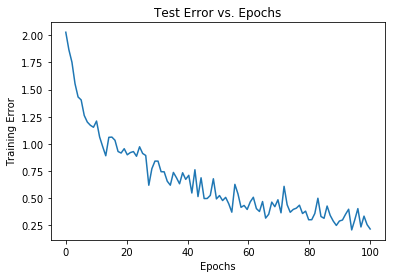

In [72]:
epochs = np.linspace(0, len(trainingErrors), len(trainingErrors))

plt.plot(epochs, trainingErrors)
plt.ylabel('Training Error')
plt.xlabel('Epochs')
plt.title('Test Error vs. Epochs')
plt.show()

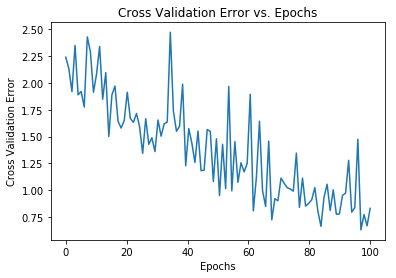

In [73]:
plt.plot(epochs, crossErrors)
plt.ylabel('Cross Validation Error')
plt.xlabel('Epochs')
plt.title('Cross Validation Error vs. Epochs')
plt.show()

In [80]:
probability = tf.nn.softmax(model.L8)
prediction = tf.argmax((probability), axis=1)
guesses = s.run((prediction), feed_dict={model.x: fixShape(cnnTraining), model.drop: DROP_OUT_RATE})

count = 0
corr = 0
categoriesRight = np.zeros(10)
for cnnTrainingLabel in cnnTrainingLabels:
    if (np.argmax(cnnTrainingLabel)) == guesses[count]:
        corr += 1
        categoriesRight[np.argmax(cnnTrainingLabel)] += 1
    count += 1

print("The cnn neural network is " + str((corr / len(guesses)) * 100) + "% accurate on the training data")
print(acceptedWords)
count = 0
print((categoriesRight / numTrainingSamples) * 100)

The cnn neural network is 76.0% accurate on the training data
['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
[ 78.54166667  75.20833333  81.5625      68.85416667  73.02083333
  74.58333333  79.47916667  82.1875      71.66666667  74.89583333]


In [81]:
probability = tf.nn.softmax(model.L8)
prediction = tf.argmax((probability), axis=1)
guesses = s.run((prediction), feed_dict={model.x: fixShape(cnnTest), model.drop: DROP_OUT_RATE})

count = 0
corr = 0
categoriesRight = np.zeros(10)
for cnnTestLabel in cnnTestLabels:
    if (np.argmax(cnnTestLabel)) == guesses[count]:
        corr += 1
        categoriesRight[np.argmax(cnnTestLabel)] += 1
    count += 1
    
print("The cnn neural network is " + str((corr / len(guesses)) * 100) + "% accurate on the test data")
print(acceptedWords)
print((categoriesRight / numTestSamples) * 100)

The cnn neural network is 48.291666666666664% accurate on the test data
['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
[ 57.08333333  50.41666667  57.5         31.25        47.5         42.91666667
  50.41666667  57.08333333  44.58333333  44.16666667]
